In [ ]:
!pip install -q "git+https://github.com/DavidLandup0/deepvision"

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 5.8 MB/s eta 0:00:00


In [ ]:
import deepvision
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [ ]:
def process_image(datapoint):
   input_image = tf.image.resize(datapoint['image'], (128, 128))
   input_mask = tf.image.resize(
   datapoint['segmentation_mask'], (128, 128), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)

   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

train_set, test_set = dataset['train'], dataset['test']

TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_set = train_set.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
test_set = test_set.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteJSDZSZ/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteJSDZSZ/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
train_set = train_set.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.batch(BATCH_SIZE)

In [ ]:
import matplotlib.pyplot as plt

def display(display_list):
  plt.figure(figsize=(8, 4))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

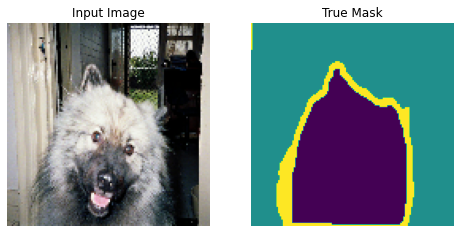

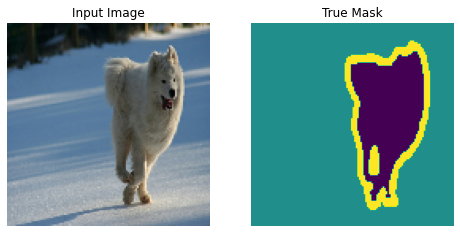

In [ ]:
for images, masks in train_set.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [ ]:
model = deepvision.models.SegFormerB0(input_shape=(128, 128, 3), 
                                      num_classes=3, 
                                      softmax_output=True,
                                      backend='tensorflow')
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "private___seg_former_tf"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 mit_b0_backbone (__MiTTF)      [(None, 32, 32, 32)  3319392     ['input_2[0][0]']                
                                , (None, 16, 16, 64                                               
                                ),                                                                
                                 (None, 8, 8, 160),                                               
                                 (None, 4, 4, 256)]                         

In [ ]:
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_set, 
                          epochs=15,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_set)

Epoch 1/15
57/57 [==============================] - 77s 363ms/step - loss: 0.8162 - accuracy: 0.6670 - val_loss: 1.8522 - val_accuracy: 0.6005
Epoch 2/15
57/57 [==============================] - 13s 225ms/step - loss: 0.6461 - accuracy: 0.7371 - val_loss: 0.9638 - val_accuracy: 0.7225
Epoch 3/15
57/57 [==============================] - 13s 225ms/step - loss: 0.5974 - accuracy: 0.7593 - val_loss: 0.7181 - val_accuracy: 0.7417
Epoch 4/15
57/57 [==============================] - 13s 228ms/step - loss: 0.5544 - accuracy: 0.7791 - val_loss: 0.6865 - val_accuracy: 0.7412
Epoch 5/15
57/57 [==============================] - 13s 230ms/step - loss: 0.5151 - accuracy: 0.7954 - val_loss: 0.6677 - val_accuracy: 0.7415
Epoch 6/15
57/57 [==============================] - 13s 231ms/step - loss: 0.4927 - accuracy: 0.8053 - val_loss: 0.5940 - val_accuracy: 0.7710
Epoch 7/15
57/57 [==============================] - 13s 232ms/step - loss: 0.4593 - accuracy: 0.8183 - val_loss: 0.5974 - val_accuracy: 0.7695

<ipython-input-12-732a1617cda9>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 3)


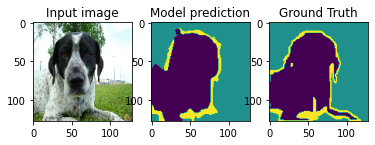

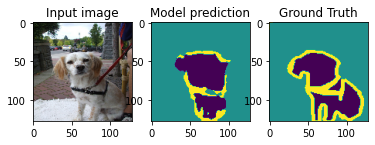

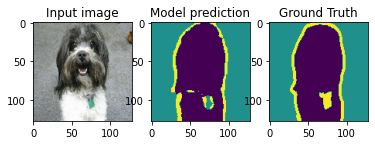

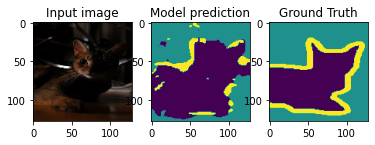

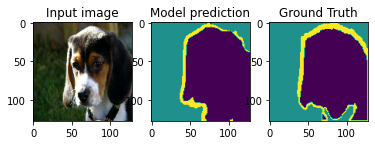

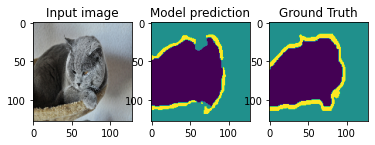

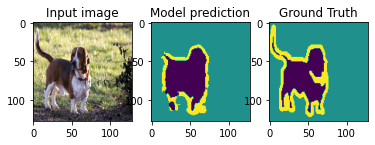

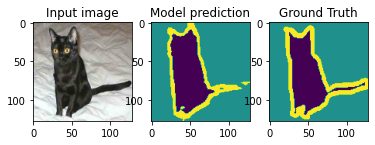

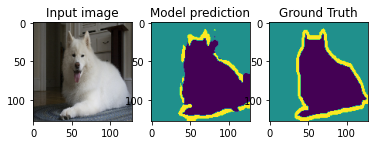

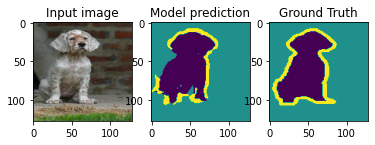

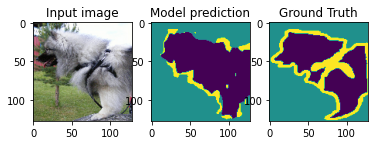

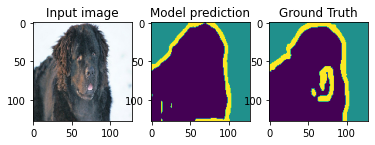

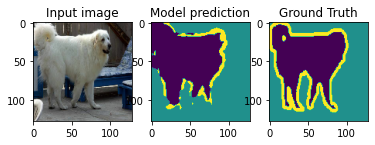

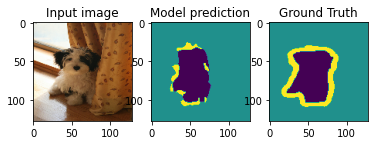

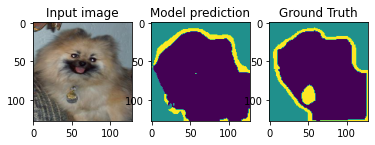

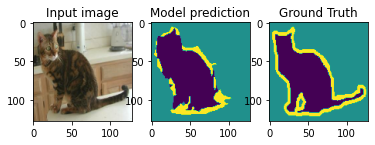

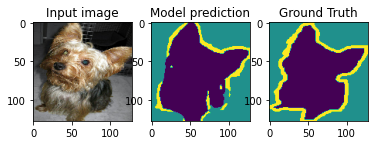

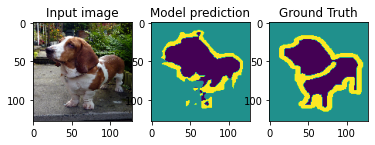

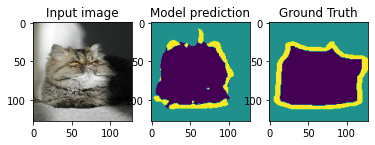

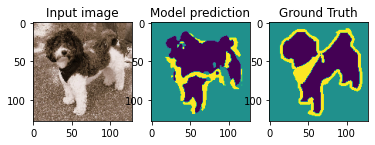

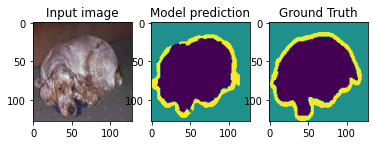

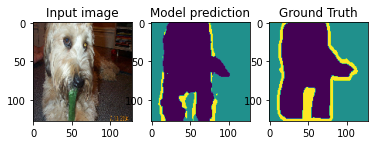

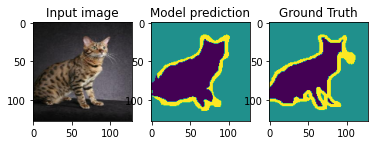

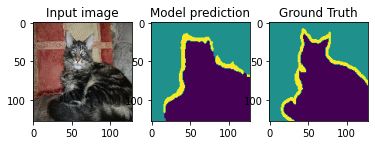

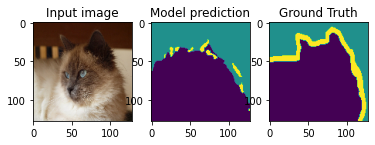

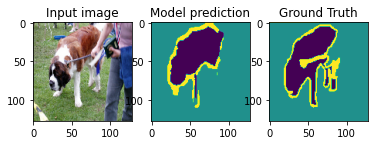

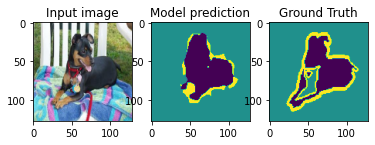

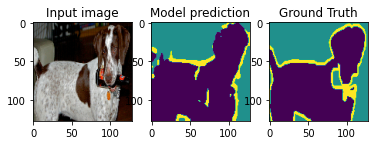

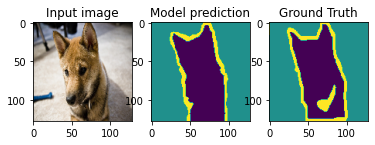

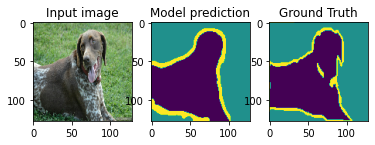

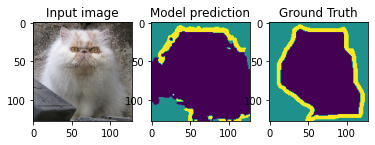

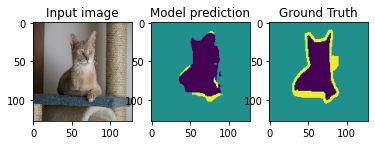

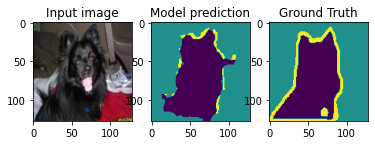

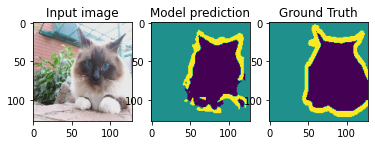

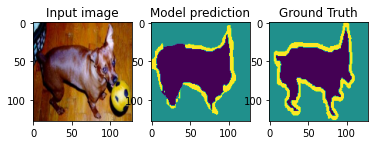

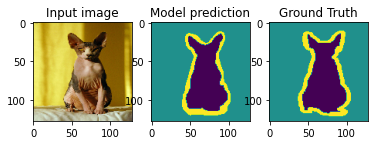

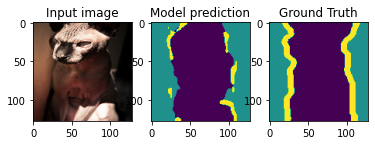

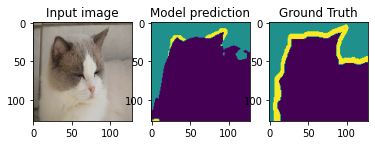

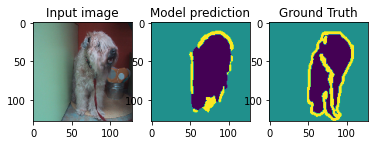

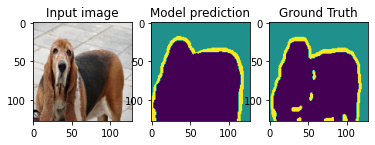

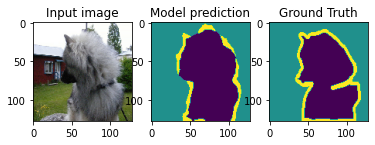

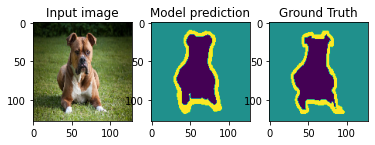

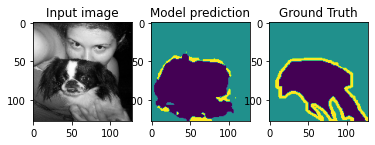

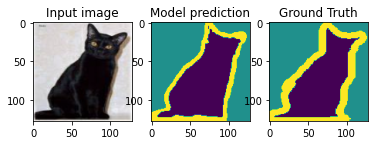

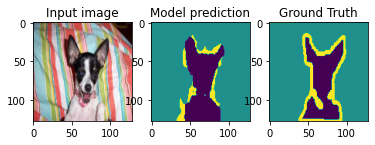

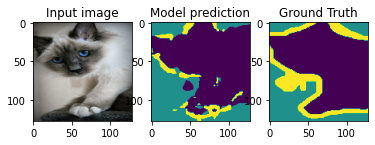

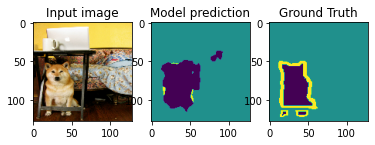

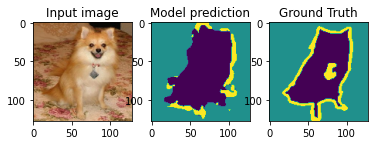

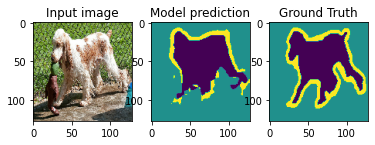

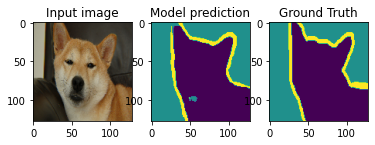

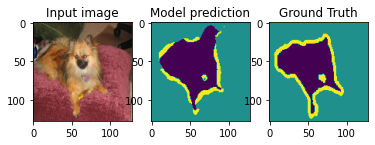

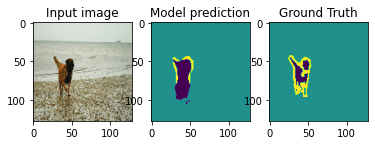

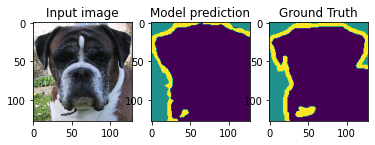

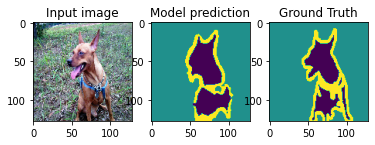

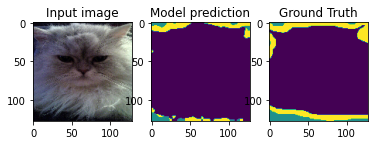

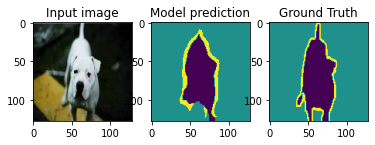

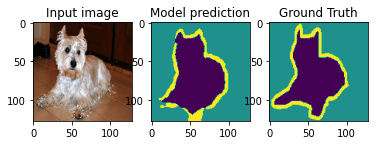

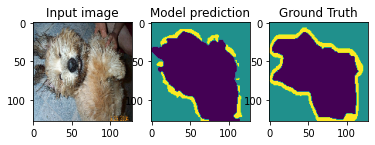

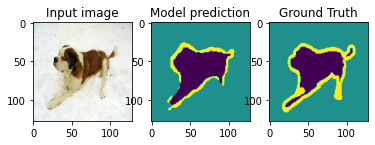

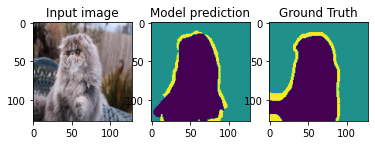

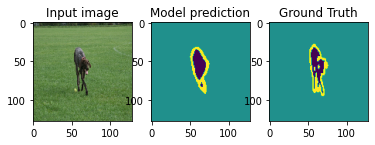

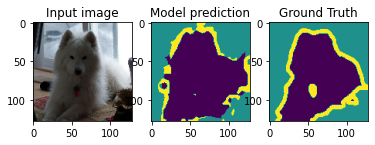

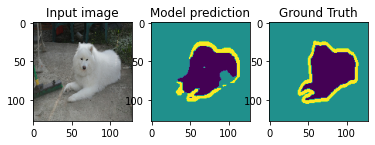

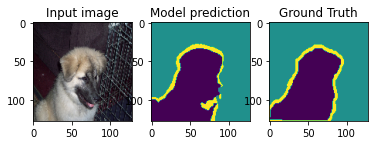

In [ ]:
for images, masks in train_set.take(1):
  inputs, targets = images, masks
  outs = model(inputs)
  outs = tf.argmax(outs, -1)
  
  for inp, out, target in zip(inputs, outs, targets):
      fig, ax = plt.subplots(1, 3)
      ax[0].imshow(inp.numpy())
      ax[1].imshow(out.numpy())
      ax[2].imshow(target.numpy())
        
      ax[0].set_title('Input image')
      ax[1].set_title('Model prediction')
      ax[2].set_title('Ground Truth')